In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("✅ Libraries loaded successfully.")

✅ Libraries loaded successfully.


In [2]:
# Your main dataset directory
base_dir = "D:/dataset1/train"

fallen_dir = os.path.join(base_dir, "fallen")
not_fallen_dir = os.path.join(base_dir, "not_fallen")

# Temporary folders for split data
split_base = r"D:/dataset1_split"
train_dir = os.path.join(split_base, "train")
val_dir = os.path.join(split_base, "val")
test_dir = os.path.join(split_base, "test")

# Remove old split folders if any
if os.path.exists(split_base):
    shutil.rmtree(split_base)

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(folder, "fallen"), exist_ok=True)
    os.makedirs(os.path.join(folder, "not_fallen"), exist_ok=True)

# Split ratio
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1

def split_data(source, dest_train, dest_val, dest_test):
    images = os.listdir(source)
    random.shuffle(images)
    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    for i, img in enumerate(images):
        src_path = os.path.join(source, img)
        if i < n_train:
            dst_path = os.path.join(dest_train, img)
        elif i < n_train + n_val:
            dst_path = os.path.join(dest_val, img)
        else:
            dst_path = os.path.join(dest_test, img)
        shutil.copy(src_path, dst_path)

# Split both classes
split_data(fallen_dir,
           os.path.join(train_dir, "fallen"),
           os.path.join(val_dir, "fallen"),
           os.path.join(test_dir, "fallen"))

split_data(not_fallen_dir,
           os.path.join(train_dir, "not_fallen"),
           os.path.join(val_dir, "not_fallen"),
           os.path.join(test_dir, "not_fallen"))

print("✅ Dataset split into Train/Val/Test successfully!")


✅ Dataset split into Train/Val/Test successfully!


Found 261 files belonging to 2 classes.
Found 74 files belonging to 2 classes.
Found 39 files belonging to 2 classes.


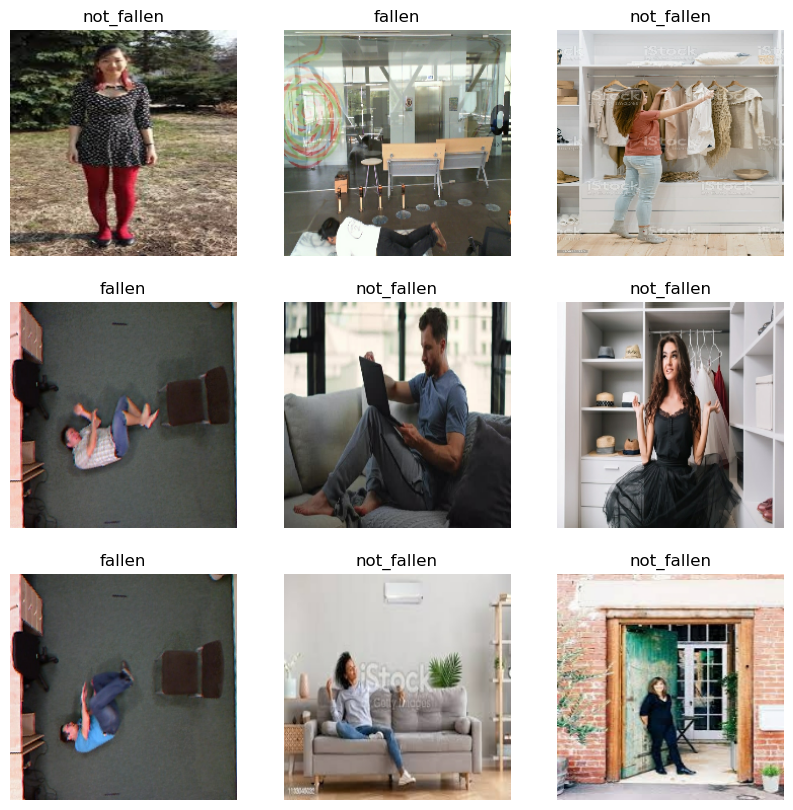

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
val_dataset = image_dataset_from_directory(val_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

# Preview few samples
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [4]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
])

# EfficientNetB0 preprocessing
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

def build_fall_model():
    input_shape = IMG_SIZE + (3,)
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights="imagenet")
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))(x)

    model = Model(inputs, outputs)
    return model, base_model

model, base_model = build_fall_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,055,972 (15.47 MB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

initial_epochs = 10

history = model.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs)

print("✅ Initial training complete.")


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 519ms/step - accuracy: 0.5441 - loss: 0.8353 - val_accuracy: 0.7162 - val_loss: 0.5896
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - accuracy: 0.6513 - loss: 0.7282 - val_accuracy: 0.7973 - val_loss: 0.5082
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.7088 - loss: 0.5599 - val_accuracy: 0.8108 - val_loss: 0.4641
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.7701 - loss: 0.5103 - val_accuracy: 0.8514 - val_loss: 0.4215
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.7510 - loss: 0.5628 - val_accuracy: 0.8514 - val_loss: 0.3950
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.7816 - loss: 0.5175 - val_accuracy: 0.8919 - val_loss: 0.3608
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.7854 - loss: 0.4214 - val_accuracy: 0.8784 - val_loss: 0.3340
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.8352 - loss: 0.4052 - val_accuracy: 0

In [6]:
base_model.trainable = True
fine_tune_at = 150  # unfreeze from layer 150 onward

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, validation_data=val_dataset,
                         epochs=total_epochs, initial_epoch=history.epoch[-1]+1)

print("✅ Fine-tuning complete.")


Epoch 11/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 680ms/step - accuracy: 0.7739 - loss: 0.5071 - val_accuracy: 0.9459 - val_loss: 0.2501
Epoch 12/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 506ms/step - accuracy: 0.8467 - loss: 0.3731 - val_accuracy: 0.9324 - val_loss: 0.2228
Epoch 13/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - accuracy: 0.8582 - loss: 0.3224 - val_accuracy: 0.9595 - val_loss: 0.1778
Epoch 14/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 496ms/step - accuracy: 0.8659 - loss: 0.3084 - val_accuracy: 0.9595 - val_loss: 0.1694
Epoch 15/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 497ms/step - accuracy: 0.8812 - loss: 0.2891 - val_accuracy: 0.9459 - val_loss: 0.1634
✅ Fine-tuning complete.


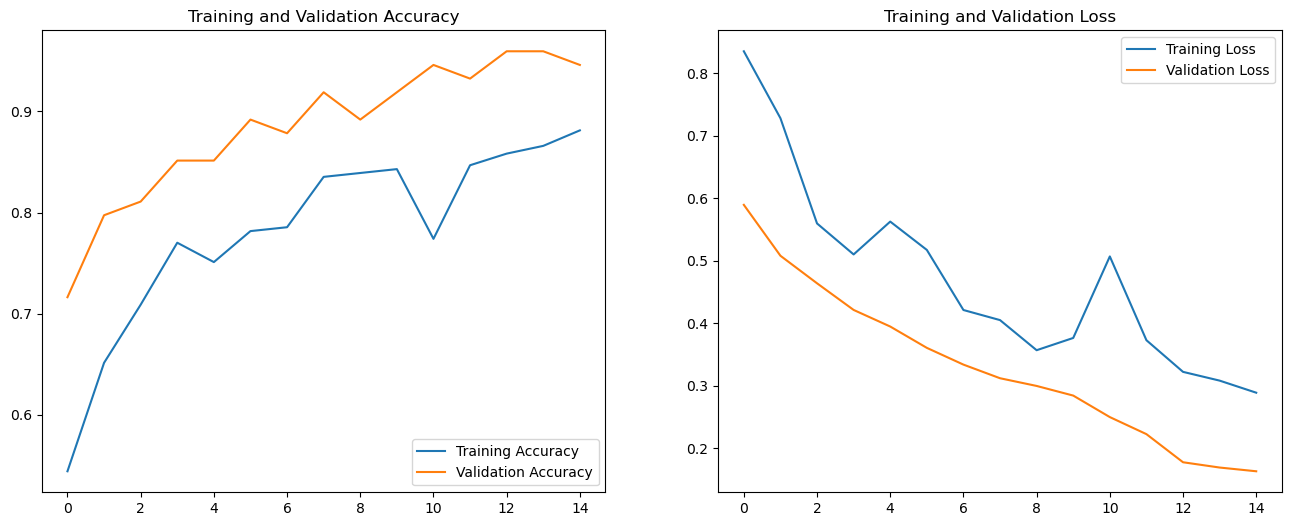

In [7]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


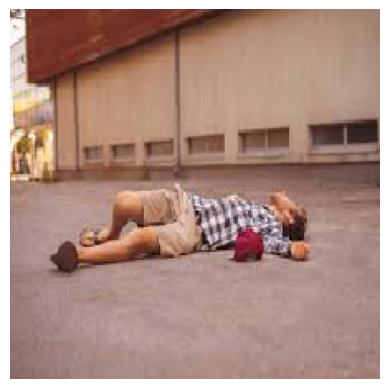

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🧠 Model Prediction Score: 0.40585747
🚨 Prediction: Fall Detected!


In [8]:
from tensorflow.keras.preprocessing import image

# Replace this with a test image from your local dataset
img_path = r"C:\Users\cheta\Downloads\images.jpg"

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

plt.imshow(img)
plt.axis("off")
plt.show()

prediction = model.predict(img_array)
print("🧠 Model Prediction Score:", prediction[0][0])

if prediction[0] < 0.5:
    print("🚨 Prediction: Fall Detected!")
else:
    print("✅ Prediction: No Fall Detected.")


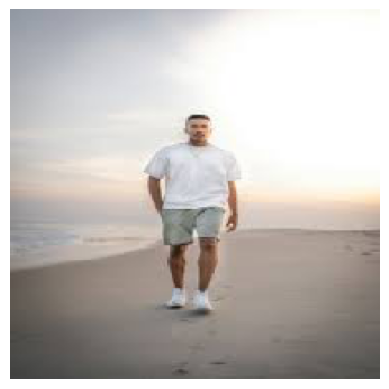

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
🧠 Model Prediction Score: 0.96142066
✅ Prediction: No Fall Detected.


In [9]:

from tensorflow.keras.preprocessing import image

# Replace this with a test image from your local dataset
img_path = r"C:\Users\cheta\Downloads\download.jpg"

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

plt.imshow(img)
plt.axis("off")
plt.show()

prediction = model.predict(img_array)
print("🧠 Model Prediction Score:", prediction[0][0])

if prediction[0] < 0.5:
    print("🚨 Prediction: Fall Detected!")
else:
    print("✅ Prediction: No Fall Detected.")


In [10]:
# ✅ Save model after training
model_save_path = r"D:\fall_detection_effnet.h5"
model.save(model_save_path)
print(f"✅ Model saved successfully at: {model_save_path}")


✅ Model saved successfully at: D:\fall_detection_effnet.h5


In [ ]:
import tensorflow as tf
import numpy as np
import gradio as gr
from tensorflow.keras.preprocessing import image
import cv2

# =====================================================
# ✅ Load Model
# =====================================================
model_path = r"D:\fall_detection_effnet.h5"
model = tf.keras.models.load_model(model_path, compile=False)
print("✅ Model loaded successfully!")

# =====================================================
# ✅ Preprocessing
# =====================================================
IMG_SIZE = (224, 224)

def preprocess(img):
    img = image.img_to_array(img)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.expand_dims(img, axis=0)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

# =====================================================
# ✅ Single Image Prediction
# =====================================================
def predict_single(img):
    if img is None:
        return "⚠️ Please upload an image!"
    img_pre = preprocess(img)
    pred = model.predict(img_pre)[0][0]
    return "🚨 **Fall Detected!**" if pred < 0.5 else "✅ **No Fall Detected.**"

# =====================================================
# ✅ Multiple Images Prediction
# =====================================================
def predict_multiple(imgs):
    if not imgs:
        return "⚠️ No images uploaded!"
    results = []
    for i, img in enumerate(imgs):
        img = image.load_img(img.name, target_size=IMG_SIZE)
        img_pre = preprocess(img)
        pred = model.predict(img_pre)[0][0]
        label = "🚨 Fall" if pred < 0.5 else "✅ No Fall"
        results.append(f"Image {i+1}: {label}")
    return "\n".join(results)

# =====================================================
# ✅ Live Webcam Detection
# =====================================================
def webcam_detect(frame):
    if frame is None:
        return None
    frame = np.array(frame)
    img_resized = cv2.resize(frame, IMG_SIZE)
    img_pre = np.expand_dims(img_resized, axis=0)
    img_pre = tf.keras.applications.efficientnet.preprocess_input(img_pre)
    pred = model.predict(img_pre)[0][0]

    label = "Fall" if pred < 0.5 else "No Fall"
    color = (0, 0, 255) if pred < 0.5 else (0, 255, 0)
    cv2.putText(frame, f"{label}", (30, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)
    return frame

# =====================================================
# 🎨 Gradio Frontend
# =====================================================
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        <h1 style="text-align:center; color:#2E86C1;">🧠 Fall Detection System</h1>
        <p style="text-align:center;">Detect falls using <b>EfficientNetB0</b> — supports single, multiple, and live camera detection.</p>
        """
    )

    with gr.Tab("🖼️ Single Image"):
        img_input = gr.Image(type="pil", label="Upload an Image")
        output_label = gr.Textbox(label="Prediction")
        gr.Button("🔍 Detect").click(predict_single, inputs=img_input, outputs=output_label)

    with gr.Tab("🗂️ Multiple Images"):
        multi_input = gr.Files(label="Upload Multiple Images")
        multi_output = gr.Textbox(label="Predictions")
        gr.Button("🧠 Analyze All").click(predict_multiple, inputs=multi_input, outputs=multi_output)

    with gr.Tab("🎥 Live Camera"):
        gr.Markdown("📸 Use your webcam to detect falls in real-time below.")
        live_feed = gr.Image(sources=["webcam"], streaming=True, label="🎥 Live Feed")
        live_output = gr.Image(label="Processed Output")
        live_feed.change(fn=webcam_detect, inputs=live_feed, outputs=live_output)

    gr.Markdown("<p style='text-align:center;color:gray;'>Developed with ❤️ using TensorFlow & Gradio</p>")

# =====================================================
# 🚀 Launch App
# =====================================================
link = demo.launch(share=True, debug=True)
print("\n🌐 Your public access link:")
print(link.share_url if hasattr(link, 'share_url') else "⚠️ Copy the link from Gradio output above.")


✅ Model loaded successfully!
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://aea8075eee38cb910a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
